The tutorials use PyTorch. You will need to load the following dependencies.

In [2]:
import random

import PIL
import imageio
import matplotlib.pyplot as plt
import numpy as np
import skimage.transform
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
from torchvision import datasets, transforms
from IPython import display

The code below helps visualize PyTorch tensors as images, loads the MNIST training set, and provides training and test functions just like in the previous two tutorials.

In [3]:
%matplotlib inline

def show(img):
    """Show PyTorch tensor img as an image in matplotlib."""
    npimg = img.cpu().detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.grid(False)
    plt.gca().axis('off')

def display_thumb(img):
  display.display(transforms.Resize(128)(img))

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# Load the training and test dataset.
mnist_train = datasets.MNIST('/tmp/mnist', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('/tmp/mnist', train=False, download=True, transform=transforms.ToTensor())

# Size of the batches the data loader will produce.
batch_size = 64

# This creates the dataloaders.
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [6]:
def train(model, criterion, data_loader, optimizer, num_epochs):
    """Simple training loop for a PyTorch model.""" 
    
    # Make sure model is in training mode.
    model.train()
    
    # Move model to the device.
    model.to(device)
    
    # Exponential moving average of the loss.
    ema_loss = None
    
    # Loop over epochs.
    for epoch in range(num_epochs):    
      
    # Loop over data.
      for batch_idx, (data, target) in enumerate(data_loader):
            
          # Forward pass.
          output = model(data.to(device))
          loss = criterion(output.to(device), target.to(device))
          
          # Backward pass.
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          # NOTE: It is important to call .item() on the loss before summing.
          if ema_loss is None:
            ema_loss = loss.item()
          else:
            ema_loss += (loss.item() - ema_loss) * 0.01 
          
      # Print out progress the end of epoch.
      print('Train Epoch: {} \tLoss: {:.6f}'.format(
            epoch, ema_loss),
      )
              
              
def test(model, data_loader):
    """Measures the accuracy of a model on a data set."""
    
    # Make sure the model is in evaluation mode.
    model.eval()
    correct = 0

    # We do not need to maintain intermediate activations while testing.
    with torch.no_grad():   
        
        # Loop over test data.
        for data, target in data_loader:
          
            # Forward pass.
            output = model(data.to(device))
            
            # Get the label corresponding to the highest predicted probability.
            pred = output.argmax(dim=1, keepdim=True)
            
            # Count number of correct predictions.
            correct += pred.cpu().eq(target.view_as(pred)).sum().item()

    # Print test accuracy.
    percent = 100. * correct / len(data_loader.dataset)
    print(f'Accuracy: {correct}/{len(data_loader.dataset)} ({percent:.0f}%)')
    return percent
   

## ResNets

We are going train a deep neural network using residual connections [2].

The network below has a list of `conv_blocks`. Each convolutional block is convolution layer followed by a ReLU with optional pooling.

[2] He, Kaiming, et al. "Identity mappings in deep residual networks." European conference on computer vision. Springer, Cham, 2016.

**Task**. Implement residual connections within `apply_conv_block`. Residual connection sum the output of a convolutional block with its input. Note that if the output and input have different sizes, you should skip the residual connection for that layer.

In [7]:
class DeepConvolutionalNetwork(nn.Module):
  """Convolutional network that can go arbitrary deep."""
  
  def __init__(self, num_repeated_layers=1, use_residuals=False):
    super().__init__()
    num_channels = 8
    self.use_residuals = use_residuals

    conv_blocks = []
    # 1x28x28 -> 8x12x12.
    conv_blocks.append(nn.Sequential(
      nn.Conv2d(1, num_channels, kernel_size=5),
      nn.MaxPool2d(2),
      nn.ReLU(inplace=True),
    ))
    for _ in range(num_repeated_layers):
      conv_blocks.append(nn.Sequential(
        nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1),          
        nn.ReLU(inplace=True),
      ))
    # 8x12x12 -> 8x4x4.
    conv_blocks.append(nn.Sequential(
      nn.Conv2d(num_channels, num_channels, kernel_size=5),
      nn.MaxPool2d(2),
      nn.ReLU(inplace=True),
    ))
    # It's important to wrap layers into ModuleList so the PyTorch knows that
    # the self.conv_blocks has parameters to optimize.
    self.conv_blocks = nn.ModuleList(conv_blocks)
    self.linear = nn.Linear(num_channels * 4 ** 2, 10)  
   
  def apply_conv_block(self, conv_block, x):
    output = conv_block(x)
    if not self.use_residuals:
      return output
    else:
      ###########################################################################
      # Implement the residual connection below.                                #
      ###########################################################################
            


  def forward(self, x):
    for block in self.conv_blocks:
      x = self.apply_conv_block(block, x) 
    x = self.linear(x.view(x.size(0), -1))
    return x


Let's look at the modules in our deep network.

In [9]:
# Print the structure of a (residual) network with 3 convolutional layers.
DeepConvolutionalNetwork(3)

DeepConvolutionalNetwork(
  (conv_blocks): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (4): Sequential(
      (0): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU(inplace=True)
    )
  )
  (linear): Linear(in_features=128, out_features=10, bias=True)
)

Now we are going to train the model with increasing number of layers with and without residual connections. What do you observe?

In [12]:
for num_layer in 1, 5:
  for use_residual in [False, True]:
    print(f'Training a neural network with {num_layer} layers and use_residual={use_residual}')
    conv_model = DeepConvolutionalNetwork(num_layer, use_residuals=use_residual)
    optimizer = torch.optim.SGD(conv_model.parameters(), lr=1e-1)
    train(conv_model, nn.CrossEntropyLoss(), train_loader, optimizer, num_epochs=1)
    accuracy = test(conv_model, test_loader)
    if use_residual:
      assert accuracy > 90, 'Accuracy is very low. Check the implementation of your residual network.'
print('Done.')

Training a neural network with 1 layers and use_residual=False
Train Epoch: 0 	Loss: 0.129122
Accuracy: 9671/10000 (97%)
Training a neural network with 1 layers and use_residual=True
Train Epoch: 0 	Loss: 0.119123
Accuracy: 9665/10000 (97%)
Training a neural network with 5 layers and use_residual=False
Train Epoch: 0 	Loss: 2.299822
Accuracy: 1135/10000 (11%)
Training a neural network with 5 layers and use_residual=True
Train Epoch: 0 	Loss: 0.270471
Accuracy: 9447/10000 (94%)


## Imagenet

Imagenet is the most famous dataset for image classification that is still in use. Real ImageNet dataset is very big (~150Gb). So we will use a smaller version that contains only two classes: bees and ants.

First, download the required files and construct the dataset.

In [7]:
! rm -rf /tmp/imagenet/unpacked
! mkdir -p /tmp/imagenet/unpacked
! [[ -f /tmp/imagenet/hymenoptera_data.zip ]] || curl https://download.pytorch.org/tutorial/hymenoptera_data.zip > /tmp/imagenet/hymenoptera_data.zip
! cd /tmp/imagenet/unpacked && unzip ../hymenoptera_data.zip > /dev/null
imagenet_dataset = datasets.ImageFolder('/tmp/imagenet/unpacked/hymenoptera_data/val')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45.0M  100 45.0M    0     0  23.6M      0  0:00:01  0:00:01 --:--:-- 23.6M.1M      0  0:00:01  0:00:01 --:--:-- 23.1M


Explore the images within the dataset. Unlike MNIST or CIFAR the dataset has relatively high-resolution images that can vary in size.

ImageNet classes: ants bees
Label of image: 0 (ants). Original size: (500, 375)


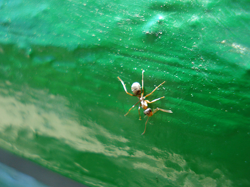

Label of image: 0 (ants). Original size: (500, 375)


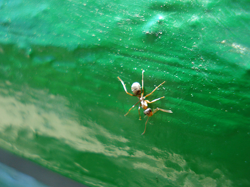

Label of image: 0 (ants). Original size: (500, 333)


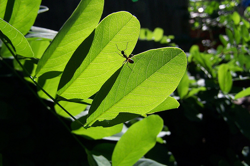

In [8]:
print('ImageNet classes:', *imagenet_dataset.classes)

# Show a random image and the corresponding target.
for i in range(3):
  img, target = random.choice(imagenet_dataset)
  print('Label of image: %d (%s). Original size: %s' % (target, imagenet_dataset.classes[target], img.size))

  # Reduce image size by half to fit the images on the page :)
  display.display(img.resize((img.size[0] // 2, img.size[1] // 2)))

A common technique to handle this is to take some segment of the image and resize it to have an image of fixed square size.

For training the segment selection is usually randomized.
For evaluation a "center" crop is used.

Actual image:


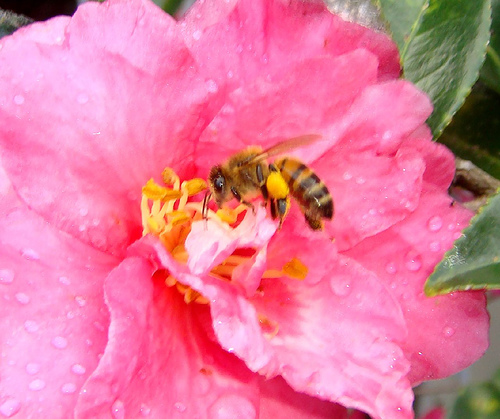

Input to the net for training


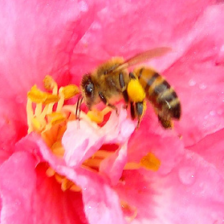

Input to the net for eval


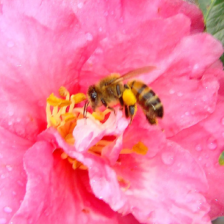

In [15]:
img, _ = random.choice(imagenet_dataset)
print('Actual image:')
display.display(img)
print('Input to the net for training')
display.display(transforms.RandomResizedCrop(224)(img))
print('Input to the net for eval')
display.display(transforms.CenterCrop(224)(transforms.Resize(256)(img)))

If a pre-trained model is used, it's important to match the transformation.

In [12]:
# This is the default transform used in ImageNet models.
inference_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# For visualization purposes we'll create a separate transform that operates in image space.
inference_transform_show = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
])

# Reload out dataset with this transform.
transformed_imagenet_dataset = datasets.ImageFolder(
    '/tmp/imagenet/unpacked/hymenoptera_data/val',
    transform=inference_transform,
)

transformed_imagenet_loader = torch.utils.data.DataLoader(transformed_imagenet_dataset, batch_size=16, shuffle=False)

# Load a pretrained model.
imagenet_resnet = torchvision.models.resnet18(pretrained=True)

# The loaded model is trained to classify image across 1000 classes. We have only two classes so have to take the two correpsonding lines from the softmax.
ANT_CLASS_ID = 310
BEE_CLASS_ID = 309
imagenet_resnet.fc.weight.data = imagenet_resnet.fc.weight.data[[ANT_CLASS_ID, BEE_CLASS_ID]]
imagenet_resnet.fc.bias.data = imagenet_resnet.fc.bias.data[[ANT_CLASS_ID, BEE_CLASS_ID]]

# If GPU available, transfer model there
if device == 'cuda':
    imagenet_resnet = imagenet_resnet.cuda()

# Check the model accuracy.
test(imagenet_resnet, transformed_imagenet_loader)

Accuracy: 147/153 (96%)


96.07843137254902

The model quality is pretty high, but there are a few mistakes. Explore misclassified images below. Why do you think the network made a mistake?


Img id=6. Excpected class ants, but predicted class bees.


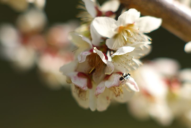

Img id=41. Excpected class ants, but predicted class bees.


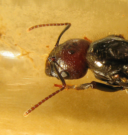

Img id=81. Excpected class bees, but predicted class ants.


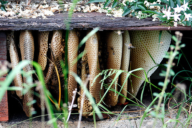

Img id=114. Excpected class bees, but predicted class ants.


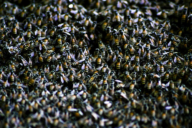

Img id=144. Excpected class bees, but predicted class ants.


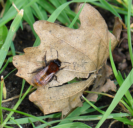

Img id=150. Excpected class bees, but predicted class ants.


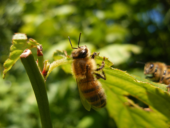

In [13]:
imagenet_resnet.eval()  # make sure the model is in evaluation mode

for i in range(len(transformed_imagenet_dataset)):
  img, _ = imagenet_dataset[i]
  tensor, target = transformed_imagenet_dataset[i]
    
  if device == 'cuda':
    tensor = tensor.cuda()
    
  _, prediction = imagenet_resnet(tensor.unsqueeze(0)).squeeze(0).cpu().max(-1)
  if prediction != target:
    print('Img id=%d. Excpected class %s, but predicted class %s.' % (
        i,
        imagenet_dataset.classes[target],
        imagenet_dataset.classes[prediction]))
    display_thumb(img)
  

**Task** As you saw, the random crop does not always catche the object. Let's understand what it does for a image. For a random image from `imagenet_dataset` sample a few random crops and find the most _bee-like_ and the most _ant-like_ ones. How do they look like?

Most ant-like


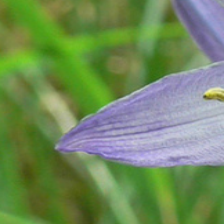

Most bee-like


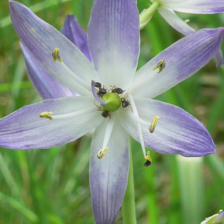

In [14]:
imagenet_resnet.eval()  # make sure the model is in evaluation mode

random_id = 40
img, _ = imagenet_dataset[random_id]

random_crops = [transforms.RandomResizedCrop(224)(img)
                for _ in range(10)]


def beeness(image):
    
  # Convert image to tensor and apply default for the dataset mean-variance normalization.
  image = transforms.ToTensor()(image)
  image = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(image)
  ###########################################################################
  # TODO: Sort the random_crops by probability of bee-ness.                 #
  # You need to compute logits and convert them to probabilities.           #
  ###########################################################################
   
  return probs[0].item()
  
random_crops = sorted(random_crops, key=beeness)

print('Most ant-like'); display.display(random_crops[0])
print('Most bee-like'); display.display(random_crops[-1])